Using device: cuda
tensor(1.6851, device='cuda:0') tensor(4.4066, device='cuda:0')
Encoded latents shape: torch.Size([1, 4, 64, 64])


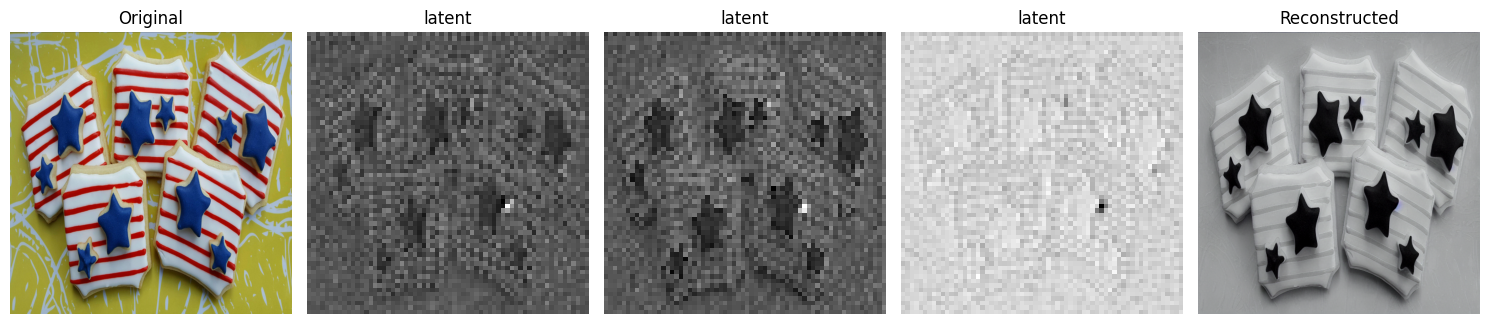

In [5]:

import torch
from diffusers import AutoencoderKL
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


#freeze ve
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    subfolder="vae"
).to(device)
vae.eval()



image_path = "/data/wangzhongtao/MVANet/data/DIS5K/DIS-TE1/im/1#Accessories#1#Bag#26345192014_f722d1ef0b_o.jpg"
original_image = Image.open(image_path).convert("RGB")
original_image = original_image.resize((512, 512), Image.Resampling.LANCZOS)

image_tensor = (torch.from_numpy(np.array(original_image)).float() / 255.0)
image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0).to(device)  # shape [1, 3, 512, 512]
image_tensor[:,1] = image_tensor[:,0]  # 将 G 通道替换为与 R 通道相同的值
image_tensor[:,2] = image_tensor[:,0]  # 将 B 通道替换为与 R 通道相同的值

################################################################################
# In[5]: 编码到潜变量
# vae.encode() 返回一个带分布信息的对象，其中包含 .latent_dist 属性
# 我们可以使用 .latent_dist.sample() 获取具体的潜变量张量
################################################################################
with torch.no_grad():
    latent_dist = vae.encode(image_tensor)
    latents = latent_dist.latent_dist.sample()   # shape [1, 4, 64, 64] (默认 SD 的通道数 & 尺寸)
    # 也可以只要均值: latents = latent_dist.latent_dist.mean

print(latents.mean(), latents.std())
print("Encoded latents shape:", latents.shape)

################################################################################
# In[6]: 从潜变量解码回图像
################################################################################
with torch.no_grad():
    decoded = vae.decode(latents).sample  # shape [1, 3, 512, 512]

# 张量转换为 PIL 图像进行显示
decoded_image = decoded.squeeze(0).permute(1,2,0).cpu().numpy()
decoded_image = np.clip(decoded_image, 0, 1)  # 确保数值在 [0,1]
decoded_image_pil = Image.fromarray((decoded_image * 255).astype("uint8"))

################################################################################
# In[7]: 可视化原图和重构图
################################################################################
plt.figure(figsize=(15,5))

plt.subplot(1,5,1)
plt.title("Original")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1,5,2)
plt.title("latent")
plt.imshow(latents[0, 0].cpu().numpy(), cmap="gray")
plt.axis("off")

plt.subplot(1,5,3)
plt.title("latent")
plt.imshow(latents[0, 1].cpu().numpy(), cmap="gray")
plt.axis("off")

plt.subplot(1,5,4)
plt.title("latent")
plt.imshow(latents[0, 2].cpu().numpy(), cmap="gray")
plt.axis("off")

plt.subplot(1,5,5)
plt.title("Reconstructed")
plt.imshow(decoded_image_pil)
plt.axis("off")

plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
from DiffusionNet import DiffusionNet
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import logging
from saliency_metric import cal_fm
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

In [3]:
class DIS5KDataset(Dataset):
    def __init__(self, root_dir, phase, transform=None):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        image_dir = os.path.join(root_dir, phase, 'im')
        mask_dir = os.path.join(root_dir, phase, 'gt')
        for img_name in os.listdir(image_dir):  # img为.jpg格式,但mask为.png格式
            mask_name = img_name.split('.')[0] + '.png'
            self.image_paths.append(os.path.join(image_dir, img_name))
            self.mask_paths.append(os.path.join(mask_dir, mask_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# 定义数据增强变换
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 调整图像大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),  # 随机垂直翻转
    transforms.RandomRotation(30),  # 随机旋转
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),  # 随机裁剪
    transforms.ToTensor(),  # 转换为Tensor
    #transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])

valid_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为Tensor
    #transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])

# 加载 DIS5K 数据集
root_dir = 'data/DIS5K'  # DIS5K 数据集路径

# 创建数据集实例
train_dataset = DIS5KDataset(root_dir=root_dir, phase='DIS-TR', transform=train_transform)
valid_dataset = DIS5KDataset(root_dir=root_dir, phase='DIS-VD', transform=valid_transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=16)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False ,num_workers=16)

for i, (image, mask) in enumerate(train_loader):
    break

image = image[0][None]
mask = mask[0][None]
print(image.shape)
print(mask.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])


Encoded latents shape: torch.Size([1, 4, 64, 64])


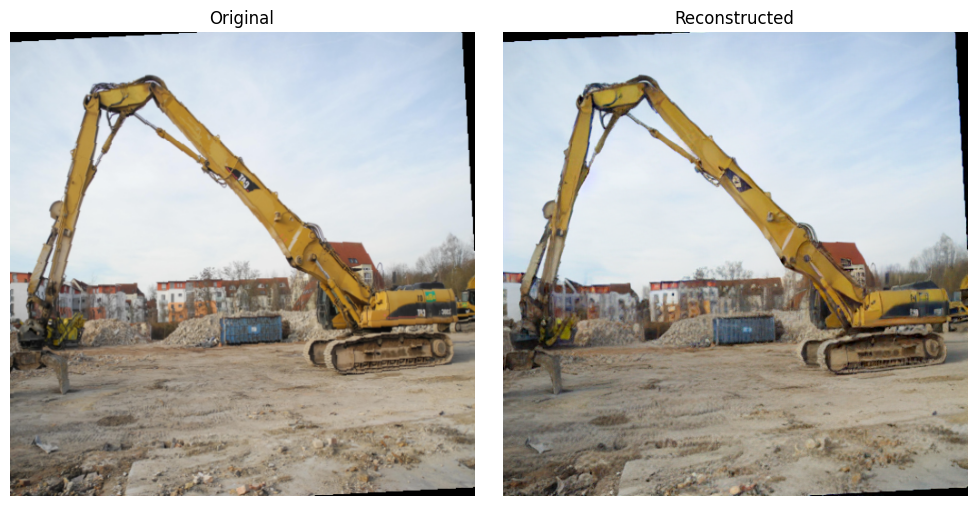

tensor(0.0020, device='cuda:0')


In [4]:
image_tensor = image.to(device)
original_image = image[0].permute(1,2,0).cpu().numpy()

with torch.no_grad():
    latent_dist = vae.encode(image_tensor)
    latents = latent_dist.latent_dist.sample()   # shape [1, 4, 64, 64] (默认 SD 的通道数 & 尺寸)
    # 也可以只要均值: latents = latent_dist.latent_dist.mean

print("Encoded latents shape:", latents.shape)

################################################################################
# In[6]: 从潜变量解码回图像
################################################################################
with torch.no_grad():
    decoded = vae.decode(latents).sample  # shape [1, 3, 512, 512]

# 张量转换为 PIL 图像进行显示
decoded_image = decoded.squeeze(0).permute(1,2,0).cpu().numpy()
decoded_image = np.clip(decoded_image, 0, 1)  # 确保数值在 [0,1]
decoded_image_pil = Image.fromarray((decoded_image * 255).astype("uint8"))

################################################################################
# In[7]: 可视化原图和重构图
################################################################################
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(decoded_image_pil)
plt.axis("off")

plt.tight_layout()
plt.show()
import torch.nn.functional as F
print(F.mse_loss(image_tensor, decoded))